In [ ]:
!pip install yfinance statsmodels tensorflow pmdarima adam LSTM

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
import time_seri_forecast as tsf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Time Series Forecasting**

***Load dataset from CSV***

In [2]:
data = pd.read_csv('/content/financial_data.csv', index_col=0, parse_dates=True)
ticker = 'TSLA'
df = data[[ticker]]

***Train_test Split***

In [3]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

***ARIMA Model***

In [4]:
try:
  arima_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
  arima_forecast = arima_model.predict(n_periods=len(test))
except Exception as e:
  print(f"Error fitting ARIMA: {e}")
  arima_forecast = np.full(len(test), np.nan)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12684.802, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12680.726, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12679.653, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12679.753, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12678.997, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12680.805, Time=1.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.585 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


***SARIMA Model***

In [5]:
try:
    sarima_model = SARIMAX(
        train, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)
    )  # Adjusted seasonal order
    sarima_fit = sarima_model.fit()
    sarima_forecast = sarima_fit.forecast(steps=len(test))
except Exception as e:
    print(f"Error fitting SARIMA: {e}")
    sarima_forecast = np.full(len(test), np.nan)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


***LSTM Model***

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

seq_length = 10
X_train, y_train = tsf.create_sequences(train_scaled, seq_length)
X_test, y_test = tsf.create_sequences(test_scaled, seq_length)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
try:
  model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
  lstm_forecast = model.predict(X_test)
  lstm_forecast = scaler.inverse_transform(lstm_forecast)
except Exception as e:
  print(f"Error fitting LSTM: {e}")
  lstm_forecast = np.full(len(test), np.nan)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


***Evaluation***

In [7]:
tsf.calculate_metrics(test,arima_forecast,'ARIMA')
tsf.calculate_metrics(test,sarima_forecast,'SARIMA')
tsf.calculate_metrics(test[seq_length:],lstm_forecast,'LSTM')

ARIMA - MAE: 89.9096, RMSE: 111.0784, MAPE: nan
SARIMA - MAE: 87.6695, RMSE: 109.2481, MAPE: nan
LSTM - MAE: 8.1972, RMSE: 11.6279, MAPE: 3.3609


***Visualization***

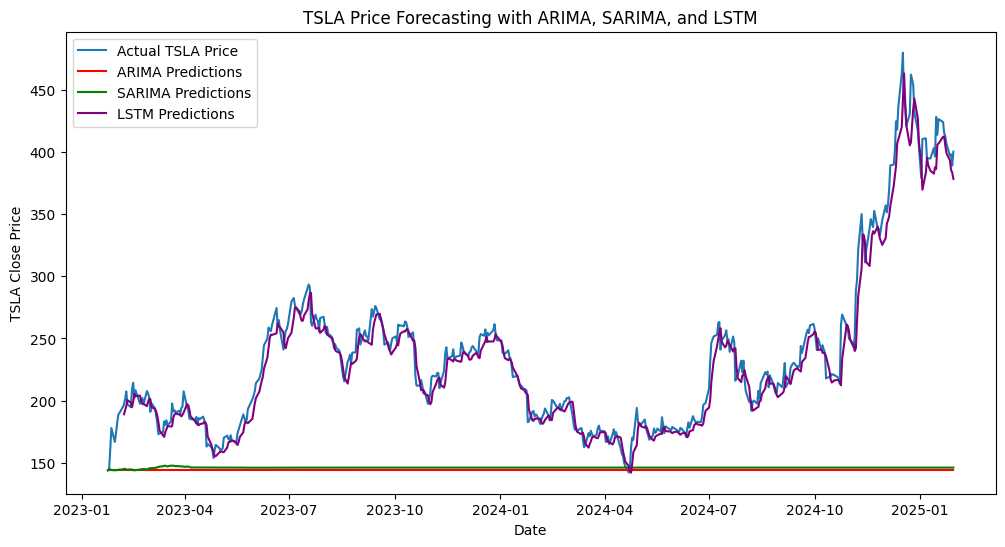

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual TSLA Price")
plt.plot(test.index, arima_forecast, label="ARIMA Predictions", color="red")
plt.plot(test.index, sarima_forecast, label="SARIMA Predictions", color="green")
plt.plot(
    test.index[seq_length:],
    lstm_forecast,
    label="LSTM Predictions",
    color="purple",
)  # Adjusted index for LSTM
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.title("TSLA Price Forecasting with ARIMA, SARIMA, and LSTM")
plt.legend()
plt.show()

In [10]:
# Ensure the lengths of the forecast arrays match the test index length
len_test = len(test)
if len(arima_forecast) != len_test:
    arima_forecast = np.resize(arima_forecast, len_test)
if len(sarima_forecast) != len_test:
    sarima_forecast = np.resize(sarima_forecast, len_test)
if len(lstm_forecast.flatten()) != len_test:
    lstm_forecast = np.resize(lstm_forecast, len_test)

# Create DataFrame and save to CSV
try:
    forecasts_df = pd.DataFrame({
        'ARIMA': arima_forecast,
        'SARIMA': sarima_forecast,
        'LSTM': lstm_forecast.flatten()
    })
    forecasts_df.to_csv('/content/forecasts.csv', index=False)
    print("Forecasts saved to /content/forecasts.csv")
except ValueError as e:
    print(f"Error creating DataFrame: {e}")

# Save the trained LSTM model
model.save('/content/lstm_model.h5')  # Save the trained LSTM model

Forecasts saved to /content/forecasts.csv


In [12]:
# Save the trained LSTM model as a .pkl file
with open('/content/lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved as lstm_model.pkl")

Model saved as lstm_model.pkl
